# Citi Surprise Index Background

This notebook will go over some of the background information of the Citi Surprise Indices and their application to trading the DB G10 Carry Index

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot

## Accessing Object

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from FXCarryDataCollect import FXData
df = FXData().get_citi_suprise()

## Basic Plotting

First start by examining the historical Citi Indices. 

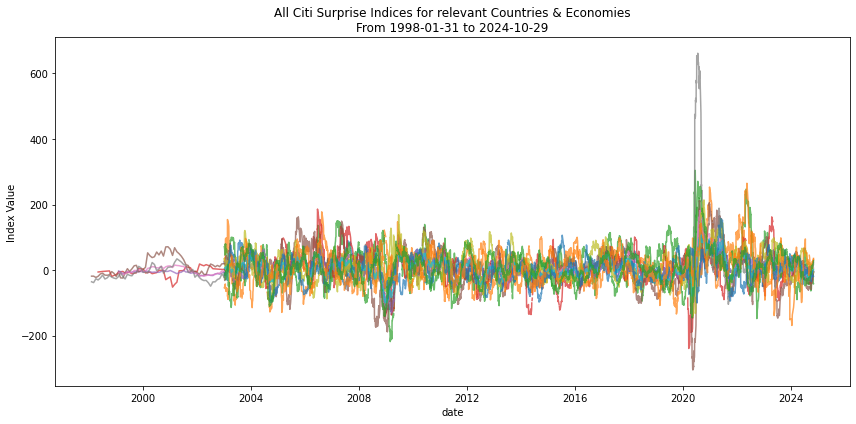

In [3]:
def plot_ts(df: pd.DataFrame) -> plt.Figure: 

    (df.pivot(
        index = "date", columns = "security", values = "value").
        plot(
            alpha   = 0.7,
            legend  = False,
            figsize = (12,6),
            ylabel  = "Index Value",
            title   = "All Citi Surprise Indices for relevant Countries & Economies\nFrom {} to {}".format(
                df.date.min(),
                df.date.max())))

    plt.tight_layout()

plot_ts(df)

In [4]:
def _run_adf(df: pd.DataFrame) -> pd.DataFrame: 

    values = (list(adfuller(df.value))[0:2])
    names  = ["test_stat", "Pvalue"]

    df_out = (pd.DataFrame(
        data = {
            "stat": values,
            "name": names}))

    return df_out

def run_adf(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.groupby(
        "security").
        apply(_run_adf).
        reset_index().
        pivot(index = "security", columns = "name", values = "stat"))

    return df_out

df_adf = run_adf(df)

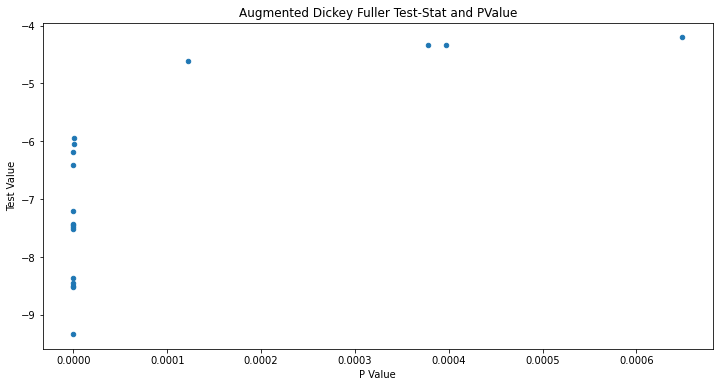

In [5]:
def plot_adf_plot(df_adf: pd.DataFrame) -> plt.Figure: 

    df_adf.plot(
        kind    = "scatter", 
        x       = "Pvalue", 
        y       = "test_stat",
        xlabel  = "P Value",
        ylabel  = "Test Value",
        figsize = (12,6),
        title   = "Augmented Dickey Fuller Test-Stat and PValue")

plot_adf_plot(df_adf)

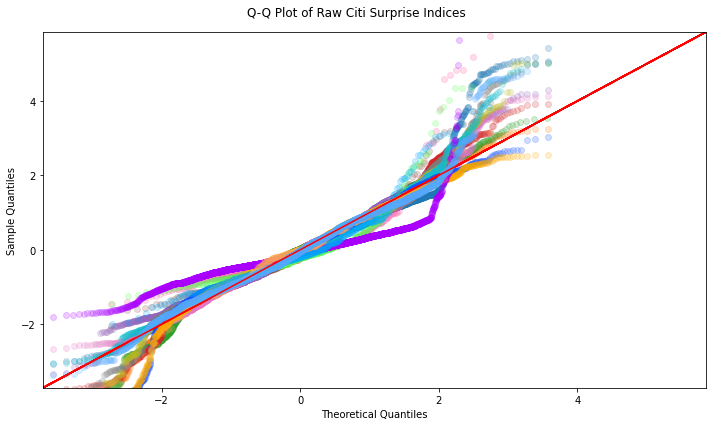

In [6]:
def plot_qqplot(df: pd.DataFrame) -> plt.Figure: 

    securities = {
        "CESIUSD" : "#1f77b4",
        "CESIEUR" : "#ff7f0e",
        "CESICNY" : "#2ca02c",
        "CESIGL"  : "#d62728",
        "CESIGBP" : "#9467bd",
        "CSIIUSD" : "#8c564b",
        "CESIJPY" : "#e377c2",
        "CESIG10" : "#7f7f7f",
        "CESICAD" : "#bcbd22",
        "CESIAUD" : "#17becf",
        "CESIEM"  : "#1a55ff",
        "CSIIEUR" : "#ff55a3",
        "CSIIGL"  : "#55ff55",
        "CESIAPAC": "#ffaa00",
        "CESIG10F": "#aa00ff",
        "CSIIEM"  : "#00aaff",
        "CSIIAUD" : "#ffaa55",
        "CESISEK" : "#55aaff"}
    
    fig, axes = plt.subplots(figsize = (10,6))
    
    for security in securities.keys():
    
        values = (df.query(
            "security == @security").
            value)
    
        qqplot(
            ax              = axes,
            data            = values, 
            fit             = True, 
            line            = "45", 
            markerfacecolor = securities[security], 
            markeredgecolor = securities[security],
            alpha           = 0.2)

    fig.suptitle("Q-Q Plot of Raw Citi Surprise Indices")
    plt.tight_layout()

plot_qqplot(df)

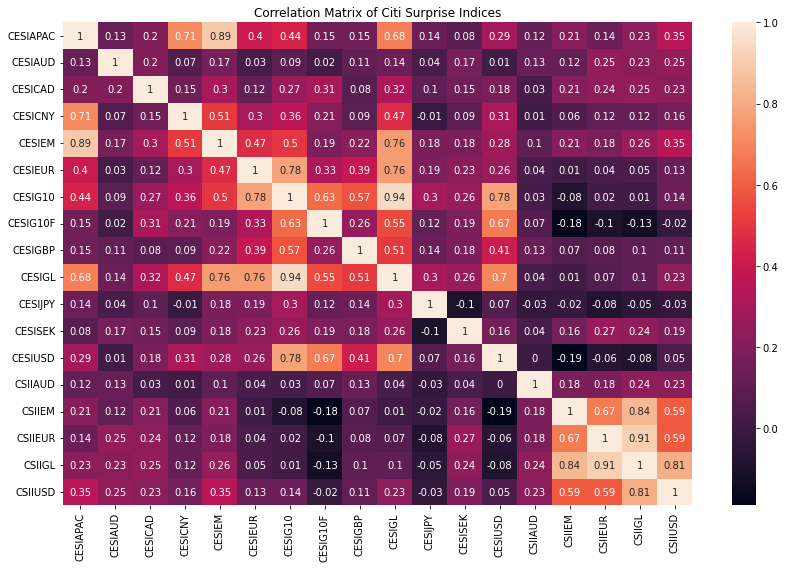

In [7]:
def plot_correlation(df: pd.DataFrame) -> plt.Figure: 

    df_corr = (df.pivot(
        index = "date", columns = "security", values = "value").
        corr().
        apply(lambda x: np.round(x, 2)))
    
    fig, axes = plt.subplots(figsize = (12,8))
    
    sns.heatmap(
        data = df_corr,
        annot = True,
        ax    = axes)
    
    axes.set_xlabel(""); axes.set_ylabel("")
    axes.set_title("Correlation Matrix of Citi Surprise Indices")
    
    plt.tight_layout()

plot_correlation(df)

In [8]:
def pca_variance(df: pd.DataFrame) -> pd.DataFrame: 

    df_wider = (df.pivot(
        index = "date", columns = "security", values = "value").
        dropna())
    
    exp_vars   = (PCA(n_components = len(df_wider.columns)).fit(df_wider).explained_variance_ratio_)
    components = [i + 1 for i in range(len(df_wider.columns))]
    
    df_vars = (pd.DataFrame(
        data = {
            "components": components,
            "exp_var"   : exp_vars}).
        set_index("components").
        assign(cum_var = lambda x: x.exp_var.cumsum()))

    return df_vars

df_vars = pca_variance(df)

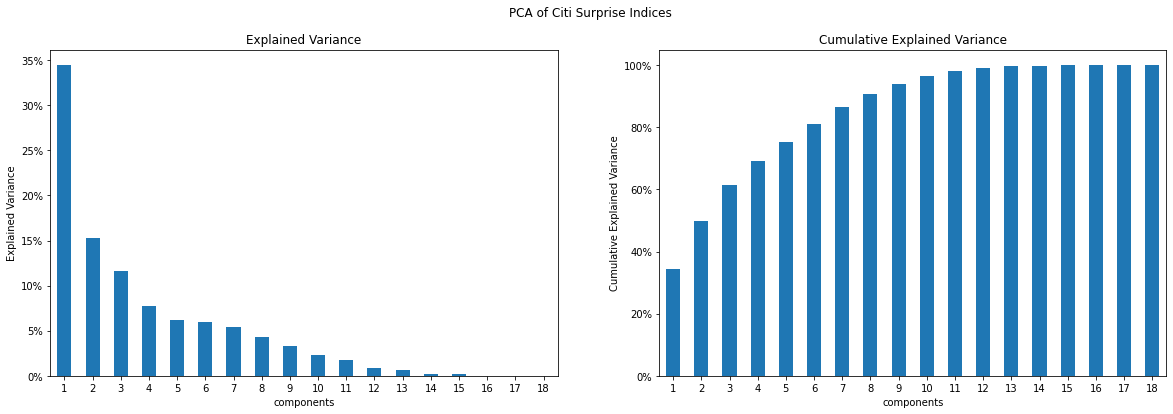

In [9]:
def plot_pca(df_vars: pd.DataFrame) -> plt.Figure: 

    df_longer = (df_vars.reset_index().melt(
        id_vars = "components"))
    
    namer = {
        "exp_var": "Explained Variance",
        "cum_var": "Cumulative Explained Variance"}
    
    fig, axes = plt.subplots(ncols = len(namer.keys()), figsize = (20,6))
    
    for variable, ax in zip(namer.keys(), axes.flatten()): 
    
        (df_longer.query(
            "variable == @variable").
            set_index("components")
            [["value"]].
            plot(
                ylabel = namer[variable],
                ax     = ax,
                kind   = "bar",
                legend = False,
                title  = namer[variable],
                rot    = 0))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
        
    fig.suptitle("PCA of Citi Surprise Indices")

plot_pca(df_vars)